Roll No.: 215229145<br>Name.: Yokeshwaran G

# Lab 9: Cascading behaviors in networks 

### Step1:load the dataset

In [21]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import sys
import os
from __future__ import division
plt.rcParams["figure.figsize"] = (20,10)
from itertools import chain
import tqdm as tqdm
from colorthief import ColorThief

warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
votes_data = pd.read_excel('ESC2018_GF.xlsx',sheet_name='Combined result')
print(votes_data.shape)
votes_data.head(5)

(26, 47)


Rank  Running order  Country  Total  Albania  Austria  Belarus  Belgium  \
0     1             22   Israel    529        6       19        8       16   
1     2             25   Cyprus    436       20        1       15       11   
2     3              5  Austria    342        2        0       10       15   
3     4             11  Germany    340       14       16        0        7   
4     5             26    Italy    308       24       10        4        6   

   Croatia  Cyprus  ...  Hungary  Moldova  Armenia  Czech Republic  Georgia  \
0       16      10  ...       16       22       18              22       15   
1        8       0  ...        7       13       19               8       10   
2        0       2  ...       11        3        7               5        9   
3        3       3  ...        1        8        5               3        7   
4       10      15  ...        6        8        3               2        5   

   Montenegro  Azerbaijan  San Marino  Italy  Australia  
0           1          13          24      9         18  
1           6          14           7      8          7  
2           0           0           0      7          5  
3           0           5          14     13         12  
4          12           5          12      0          0  

[5 rows x 47 columns]

In [4]:
votes_data.tail(5)

Rank  Running order         Country  Total  Albania  Austria  Belarus  \
21    22              3        Slovenia     64        0        5        4   
22    23              2           Spain     61        0        0        0   
23    24              9  United Kingdom     48        3        0        0   
24    25             17         Finland     46        0        0        0   
25    26              8        Portugal     39        0        0        0   

    Belgium  Croatia  Cyprus  ...  Hungary  Moldova  Armenia  Czech Republic  \
21        0        7       0  ...        0        0        0               7   
22        1        0       7  ...        0        0        0               0   
23        0        2       0  ...        0        0        0               0   
24        0        0       0  ...        0        0        0               3   
25        0        0       0  ...        0        0        0               0   

    Georgia  Montenegro  Azerbaijan  San Marino  Italy  Australia  
21        0           6           0           6      0          0  
22        0           0           0           0      0          7  
23        0           2           0           1      6          6  
24        0           0           0           0      0          4  
25        0           0           0           0      0          0  

[5 rows x 47 columns]

### Step2:Build the network out of the dataset

In [5]:
votes_melted = votes_data.melt(
    ['Rank','Running order','Country','Total'],
    var_name = 'Source Country',value_name='points')
votes_melted.head()

Rank  Running order  Country  Total Source Country  points
0     1             22   Israel    529        Albania       6
1     2             25   Cyprus    436        Albania      20
2     3              5  Austria    342        Albania       2
3     4             11  Germany    340        Albania      14
4     5             26    Italy    308        Albania      24

In [6]:
G = nx.from_pandas_edgelist(votes_melted, 
                            source='Source Country',
                            target='Country',
                            edge_attr='points',
                            create_using=nx.DiGraph())

In [7]:
print(nx.info(G))

DiGraph with 43 nodes and 1118 edges


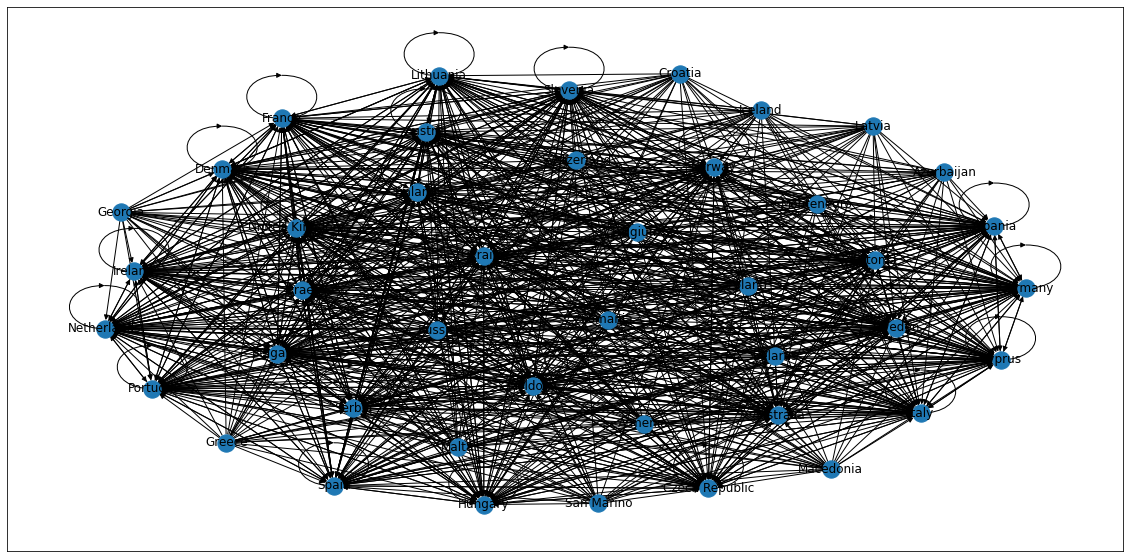

In [8]:
nx.draw_networkx(G)

### Step3:Understand the concept of information diffusion

In [10]:
dataframe1 = pd.read_csv("countries.txt")
dataframe1.to_csv('countries.csv', 
                  index = None)

In [11]:
countries = pd.read_csv('countries.csv',index_col='Country')
countries.head()

cc2   cc3  numeric  latitude  longitude
Country                                               
Afghanistan     AF   AFG        4   33.0000       65.0
Albania         AL   ALB        8   41.0000       20.0
Algeria         DZ   DZA       12   28.0000        3.0
American Samoa  AS   ASM       16  -14.3333     -170.0
Andorra         AD   AND       20   42.5000        1.6

In [12]:
pos_geo = {  node: 
           ( max(-10,min(countries.loc[node]['longitude'],55)), # fixing scale
             max(countries.loc[node]['latitude'],25)) #fixing scale
               for node in G.nodes() }

In [13]:
pos_geo = {}
for node in G.nodes():
    pos_geo[node] = (
                    max(-10,min(countries.loc[node]['longitude'],55)), # fixing scale
                    max(countries.loc[node]['latitude'],25) #fixing scale
    )

In [15]:
flags = {}
flag_color = {}
for node in tqdm.tqdm_notebook(G.nodes()):
    flags[node] = 'flags/'+(countries.loc[node]['cc3']).lower().replace(' ','')+'.png'   
    flag_color[node] =  ColorThief(flags[node]).get_color(quality=1)

  0%|          | 0/43 [00:00<?, ?it/s]

In [16]:
def RGB(red,green,blue): 
    return '#%02x%02x%02x' % (red,green,blue)

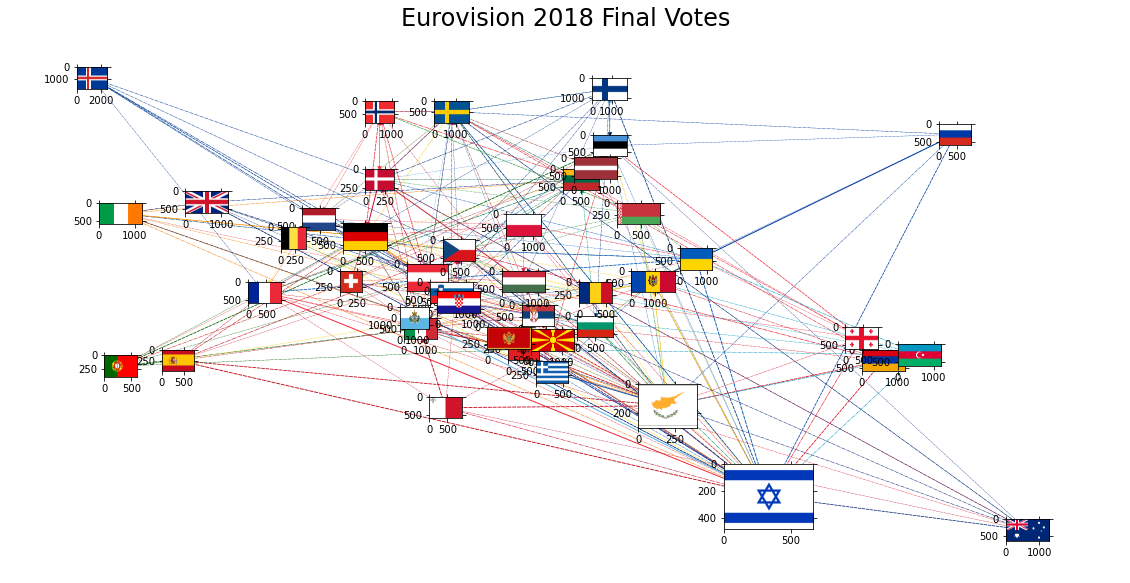

In [18]:
ax=plt.gca()
fig=plt.gcf()
plt.axis('off')
plt.title('Eurovision 2018 Final Votes',fontsize = 24)

trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform

tick_params = {'top':'off', 'bottom':'off', 'left':'off', 'right':'off',
              'labelleft':'off', 'labelbottom':'off'} #flag grid params

styles = ['dotted','dashdot','dashed','solid'] # line styles

pos = pos_geo
    
# draw edges
for e in G.edges(data=True):
    width = e[2]['points']/24 #normalize by max points
    style=styles[int(width*3)]
    if width>0.3: #filter small votes
        nx.draw_networkx_edges(G,pos,edgelist=[e],width=width, style=style, edge_color = RGB(*flag_color[e[0]]) )
        # in networkx versions >2.1 arrowheads can be adjusted

#draw nodes    
for node in G.nodes():      
    imsize = max((0.3*G.in_degree(node,weight='points')
                  /max(dict(G.in_degree(weight='points')).values()))**2,0.03)
    
    # size is proportional to the votes
    flag = mpl.image.imread(flags[node])
    
    (x,y) = pos[node]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    
    country = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    country.imshow(flag)
    country.set_aspect('equal')
    country.tick_params(**tick_params)
    
fig.savefig('images/eurovision2018_map.png')
    

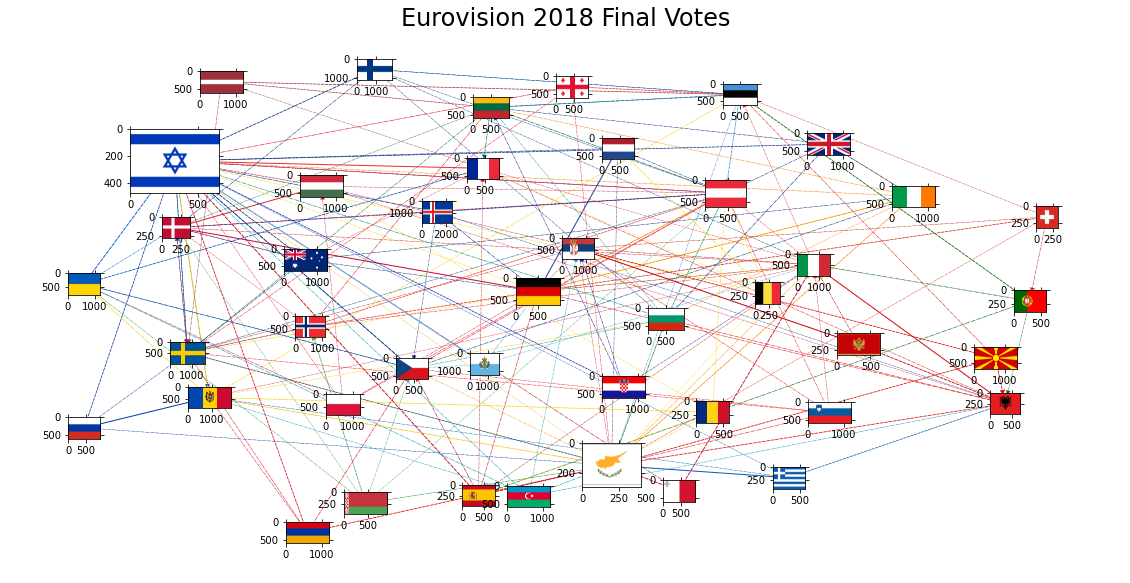

In [19]:
ax=plt.gca()
fig=plt.gcf()
plt.axis('off')
plt.title('Eurovision 2018 Final Votes',fontsize = 24)

pos = nx.layout.fruchterman_reingold_layout(G,k=1,weight = 'points',iterations=1000,scale = 2)

trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform


tick_params = {'top':'off', 'bottom':'off', 'left':'off', 'right':'off',
              'labelleft':'off', 'labelbottom':'off'} #flag grid params
styles = ['dotted','dashdot','dashed','solid'] # line styles



# draw edges
for e in G.edges(data=True):
    width = e[2]['points']/24 #normalize by max points
    style=styles[int(width*3)]
    if width>0.4: #filter small votes
        nx.draw_networkx_edges(G,pos,edgelist=[e],width=width, 
                               style=style, edge_color = RGB(*flag_color[e[0]]) )
        # in networkx versions >2.1 arrowheads can be adjusted

#draw nodes    
for node in G.nodes():    
    imsize = max((0.3*G.in_degree(node,weight='points')/max(dict(G.in_degree(weight='points')).values()))**2,0.03)
    # size is proportional to the votes
    flag = mpl.image.imread(flags[node])
    
    (x,y) = pos[node]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    
    country = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    country.imshow(flag)
    country.set_aspect('equal')
    country.tick_params(**tick_params)
    
fig.savefig('images/eurovision2018_spring.png')
    

### Step4:Build an indepent cascade model for the above network to illustrate the rumor spread dynamics

In [28]:
books = []
for i in range(5):
    books.append(pd.read_csv('data/asoiaf-book{}-edges.csv'.format(i+1)))
all_books = pd.concat(books)
all_books.head()

Source              Target        Type  weight  \
0                   Addam-Marbrand     Jaime-Lannister  Undirected       3   
1                   Addam-Marbrand     Tywin-Lannister  Undirected       6   
2                Aegon-I-Targaryen  Daenerys-Targaryen  Undirected       5   
3                Aegon-I-Targaryen        Eddard-Stark  Undirected       4   
4  Aemon-Targaryen-(Maester-Aemon)      Alliser-Thorne  Undirected       4   

   book  
0   1.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0

In [29]:
edges = all_books.groupby(['Source','Target']).agg({'weight':'sum'}).reset_index()
edges.sort_values('weight',ascending=False).head()

Source            Target  weight
1334       Eddard-Stark  Robert-Baratheon     334
2031           Jon-Snow     Samwell-Tarly     228
1965  Joffrey-Baratheon       Sansa-Stark     222
1972  Joffrey-Baratheon  Tyrion-Lannister     219
640          Bran-Stark             Hodor     209

In [30]:
GOT = nx.from_pandas_edgelist(edges, 
                            source='Source',
                            target='Target',
                            edge_attr='weight' )

In [31]:
print(nx.info(GOT))

Graph with 796 nodes and 2823 edges


In [32]:
weighted_degrees = dict(nx.degree(GOT,weight='weight'))
max_degree = max(weighted_degrees.values())

In [33]:
subG = GOT.subgraph([n for n in weighted_degrees if weighted_degrees[n]>200])
print(nx.info(subG))

Graph with 63 nodes and 496 edges


In [34]:
pos = nx.spring_layout(subG,weight='weight',iterations=20, k = 4)

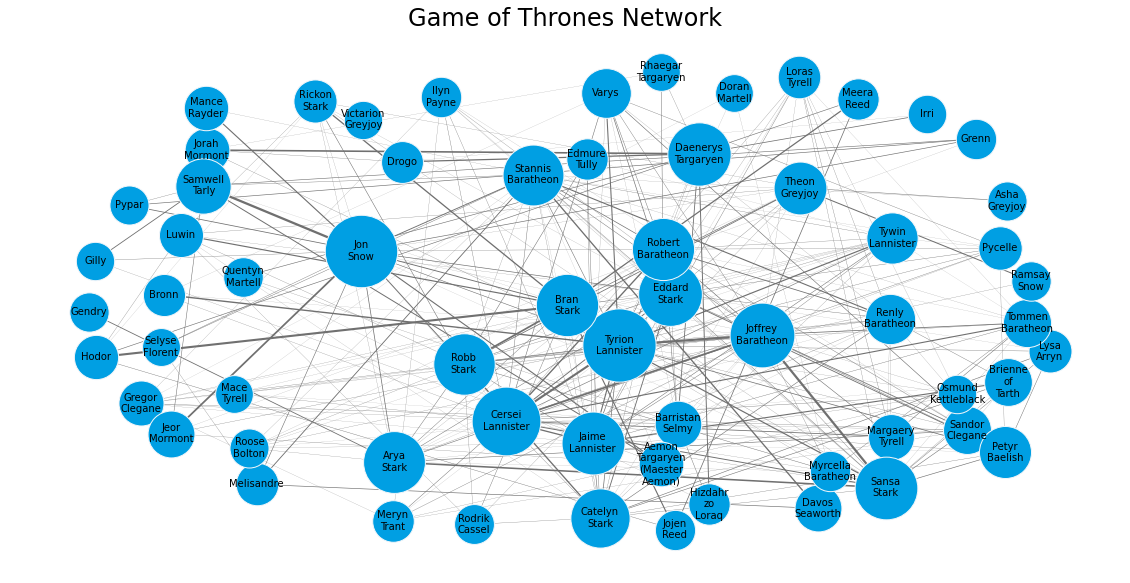

In [35]:
plt.axis('off')
plt.title('Game of Thrones Network',fontsize = 24)


for node in subG.nodes():
    size = 100*weighted_degrees[node]**0.5
    ns = nx.draw_networkx_nodes(subG,pos,nodelist=[node], node_size=size, node_color='#009fe3')
    ns.set_edgecolor('#f2f6fa')

nx.draw_networkx_labels(subG,pos,{n:n.replace('-','\n') for n in subG.nodes() if weighted_degrees[n]>100},font_size=10);

for e in subG.edges(data=True):
    if e[2]['weight']>10:
        nx.draw_networkx_edges(subG,pos,[e],width=e[2]['weight']/100,edge_color='#707070')

### Simulate independent cascade:

In [36]:
infection_times = {}

In [37]:
def independent_cascade(G,t,infection_times):
    #doing a t->t+1 step of independent_cascade simulation
    #each infectious node infects neigbors with probabilty proportional to the weight
    max_weight = max([e[2]['weight'] for e in G.edges(data=True)])
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    for n in current_infectious:
        for v in G.neighbors(n):
            if v not in infection_times:
                if  G.get_edge_data(n,v)['weight'] >= np.random.random()*max_weight:
                    infection_times[v] = t+1
    return infection_times

In [38]:
def plot_G(G,pos,infection_times,t):
    current_infectious = [n for n in infection_times if infection_times[n]==t]
    plt.figure()
    plt.axis('off')
    plt.title('Game of Thrones Network, t={}'.format(t),fontsize = 24)

    for node in G.nodes():
        size = 100*weighted_degrees[node]**0.5
        if node in current_infectious:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#feba02')
        elif infection_times.get(node,9999999)<t:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#f2f6fa')
        else:
            ns = nx.draw_networkx_nodes(G,pos,nodelist=[node], node_size=size, node_color='#009fe3')
        ns.set_edgecolor('#f2f6fa')
    nx.draw_networkx_labels(G,pos,{n:n.replace('-','\n') for n in G.nodes() if weighted_degrees[n]>100},font_size=10);

    for e in G.edges(data=True):
        if e[2]['weight']>10:
            nx.draw_networkx_edges(G,pos,[e],width=e[2]['weight']/100,edge_color='#707070')

### To illustrate the rumor spread dynamics

In [39]:
infection_times = {'Bran-Stark':-1,'Samwell-Tarly':-1,'Jon-Snow':0}

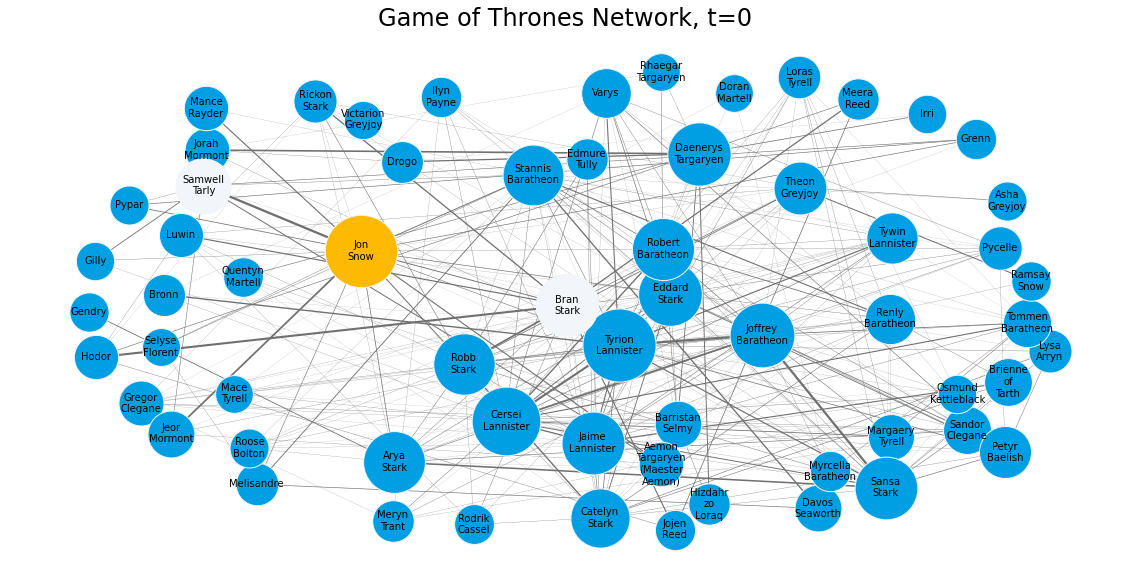

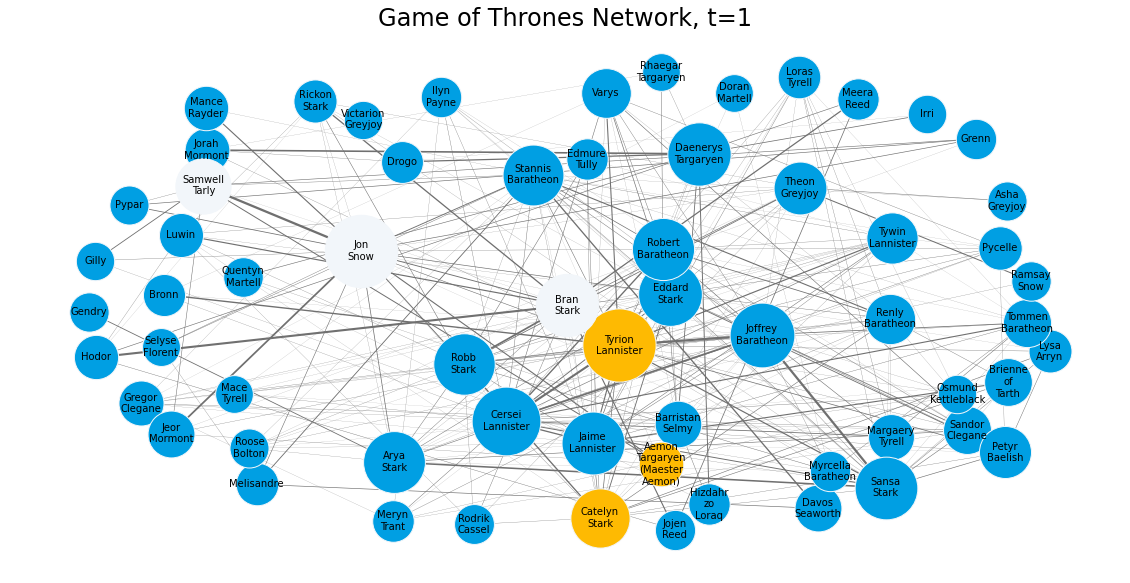

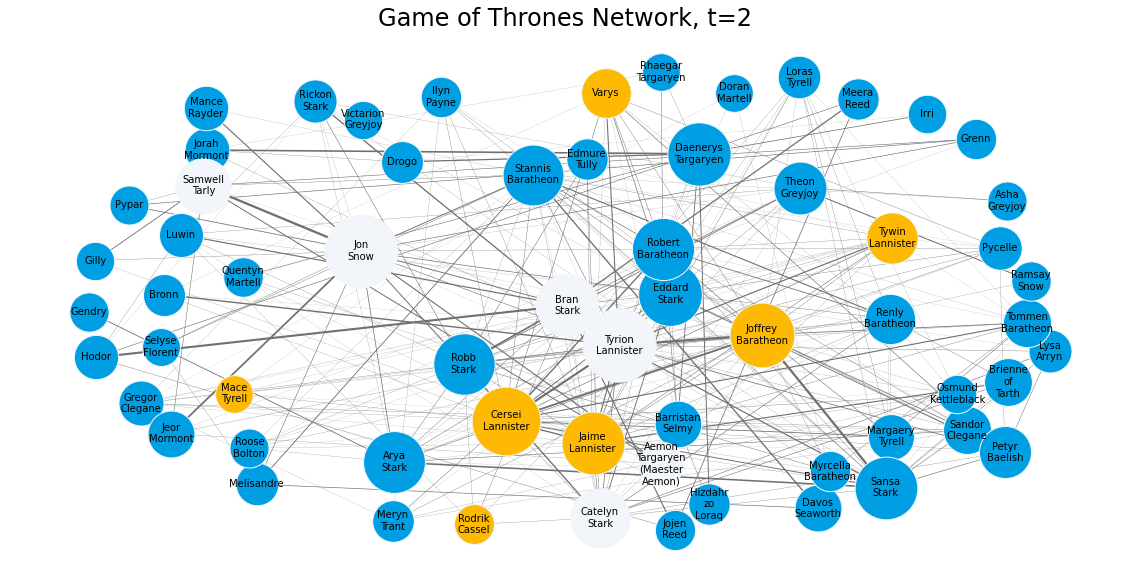

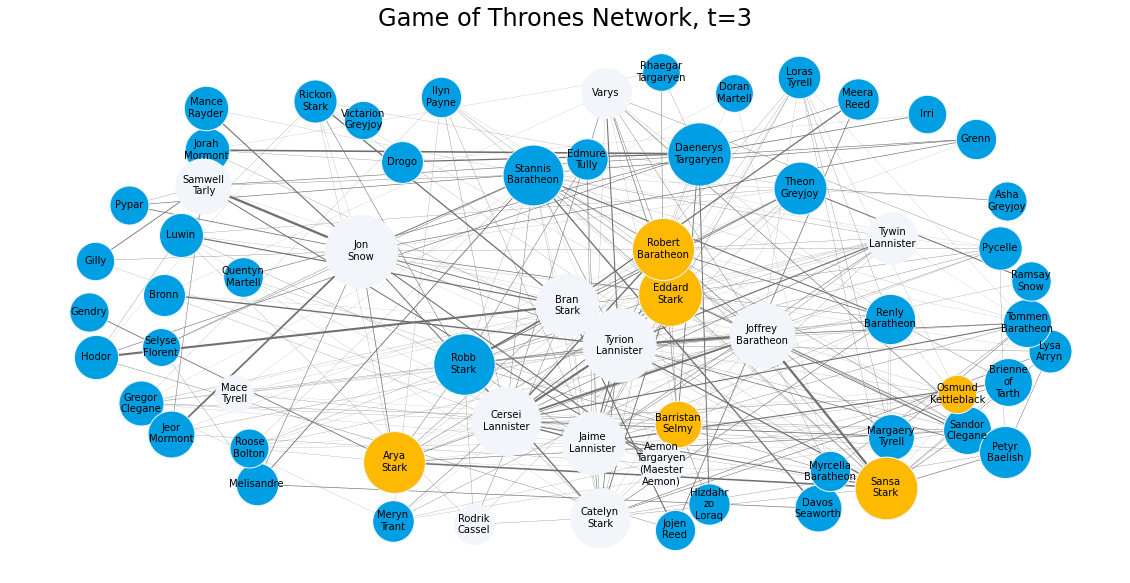

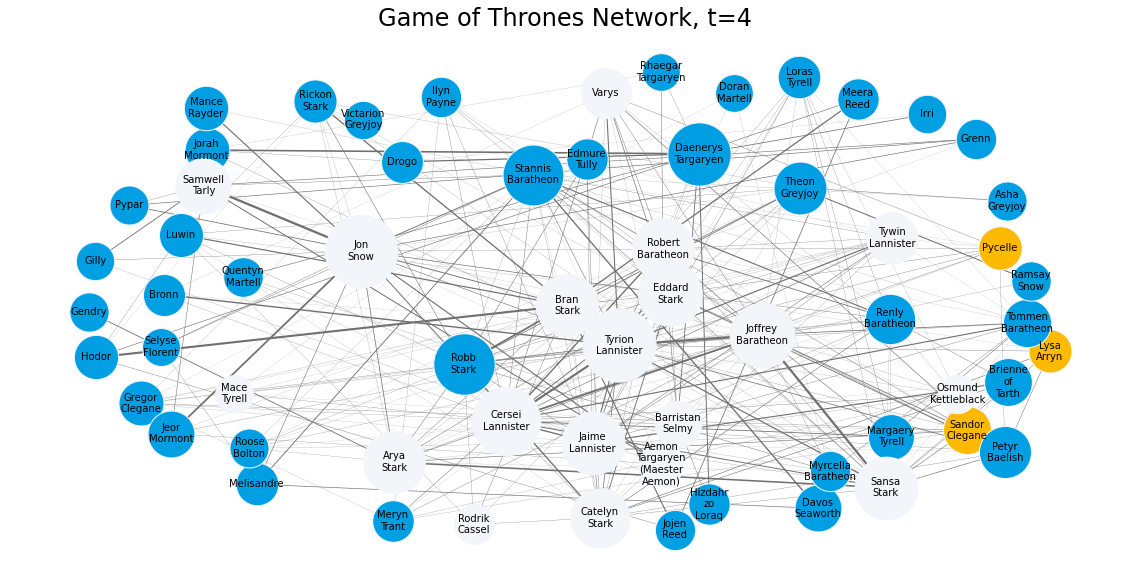

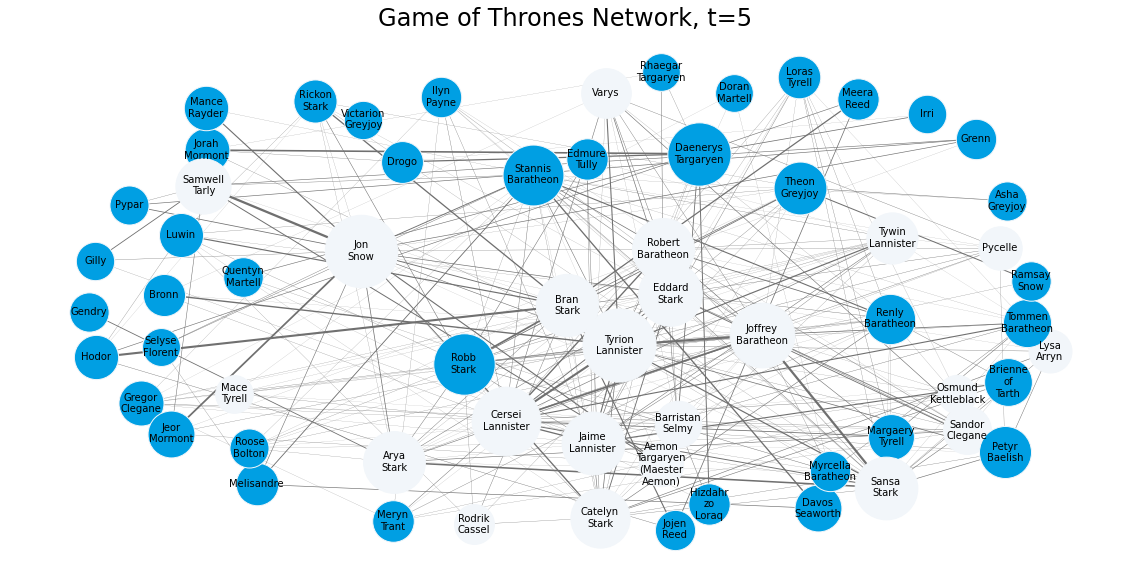

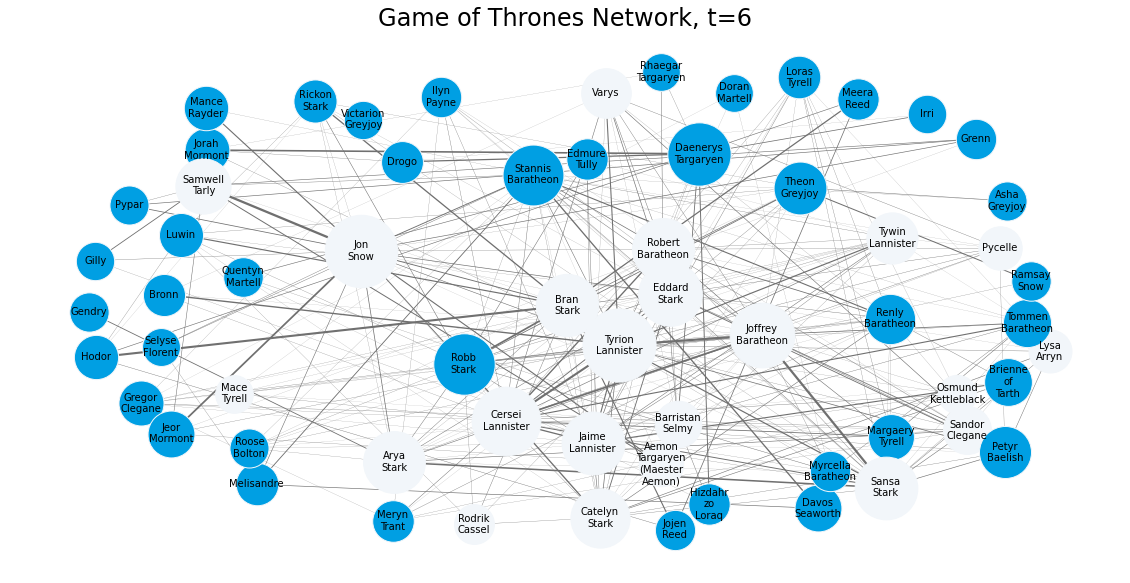

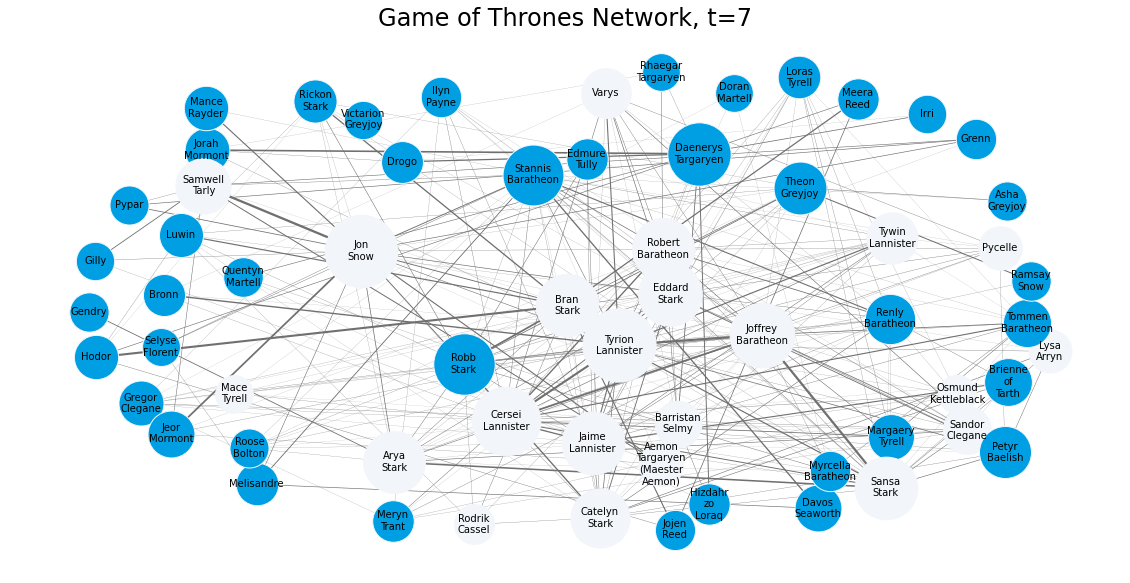

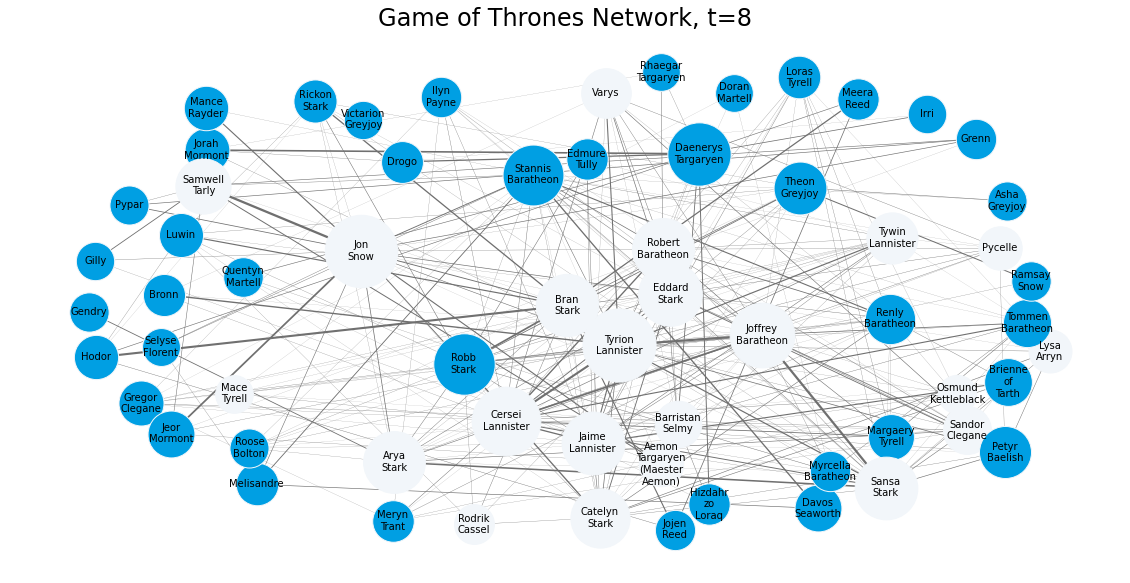

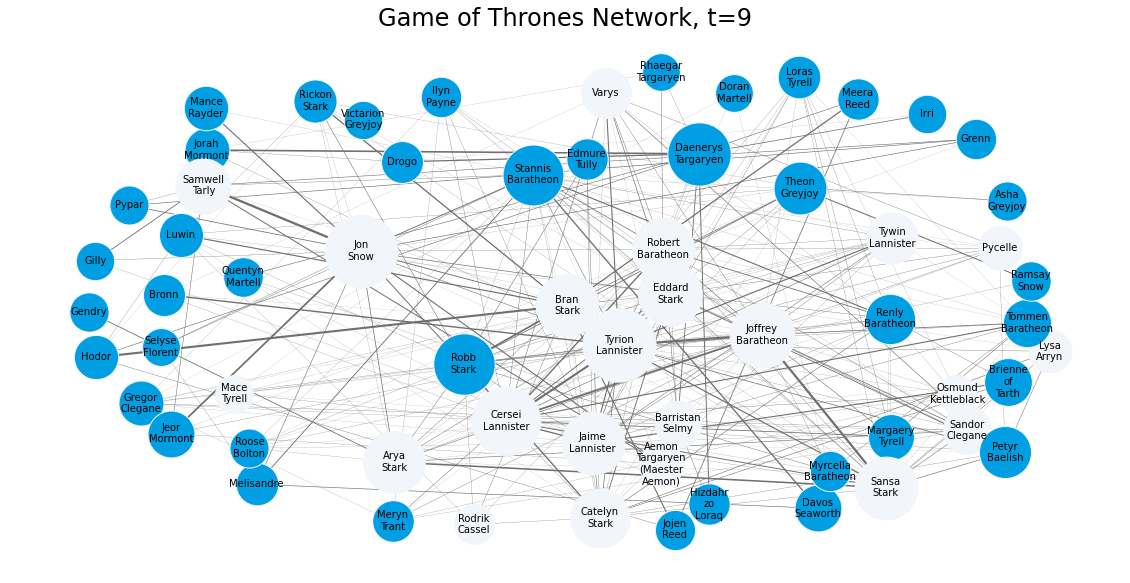

In [40]:
for t in range(10):
    plot_G(subG,pos,infection_times,t)
    infection_times = independent_cascade(subG,t,infection_times)

In [41]:
top = pd.DataFrame.from_dict(dict(nx.degree(subG)),orient='index').sort_values(0,ascending=False)
top.columns = ['Degree']
top['Weighted Degree'] =  pd.DataFrame.from_dict(dict(nx.degree(subG,weight='weight')),orient='index')
top['PageRank'] = pd.DataFrame.from_dict(dict(nx.pagerank_numpy(subG,weight='weight')),orient='index')
top['Betweenness'] =  pd.DataFrame.from_dict(dict(nx.betweenness_centrality(subG,weight='weight')),orient='index')

In [42]:
top.head()

Degree  Weighted Degree  PageRank  Betweenness
Tyrion-Lannister       40             1842  0.052710     0.036445
Robert-Baratheon       37             1271  0.037012     0.223912
Joffrey-Baratheon      35             1518  0.042829     0.033051
Cersei-Lannister       34             1627  0.046179     0.004671
Eddard-Stark           34             1330  0.037789     0.024061

In [43]:
methods = top.columns

In [44]:
max_budget = len(subG.nodes())
trials = 50
all_results = []
for budget in tqdm.tqdm_notebook(range(max_budget)):
    results = {'budget':budget}
    for method in methods:
        infections = []
        for i in range(trials):
            infected = 0
            t= 0
            infection_times = {n:0 for n in top.sort_values(method,ascending=False).index[:budget]}
            while len(infection_times)>infected:
                #t+=1
                infected = len(infection_times)
                infection_times = independent_cascade(subG,t,infection_times)
                t+=1
            infections.append(infected)
        results[method] = np.round(np.mean(infections)/len(subG.nodes()),2)

    all_results.append(results)

  0%|          | 0/63 [00:00<?, ?it/s]

In [46]:
res_df = pd.concat([pd.DataFrame.from_dict(r,orient='index').T 
                        for r in all_results]).set_index('budget')


In [47]:
res_df.index = res_df.index/len(subG.nodes())
res_df.head()

Degree  Weighted Degree  PageRank  Betweenness
budget                                                  
0.000000    0.00             0.00      0.00         0.00
0.015873    0.50             0.48      0.48         0.50
0.031746    0.50             0.50      0.53         0.53
0.047619    0.52             0.51      0.53         0.54
0.063492    0.53             0.52      0.51         0.52

### Compare the methods on a plot (percentage of infected network)

Text(0.5, 0, 'Seeding Budget (out of graph size)')

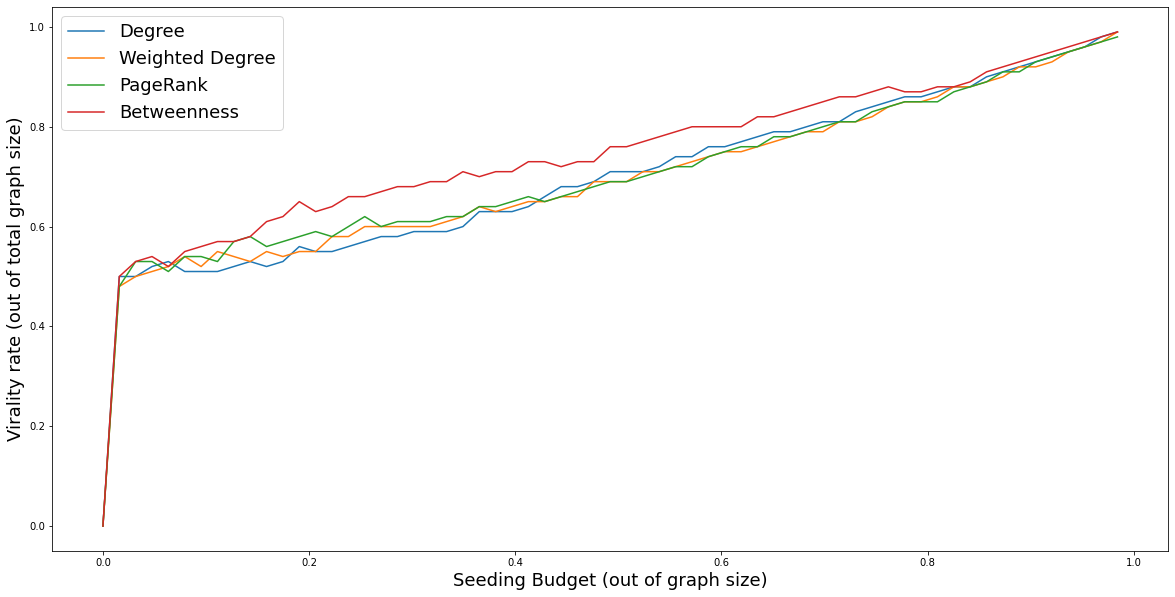

In [52]:
res_df.plot()
plt.legend(fontsize = 18)
plt.ylabel('Virality rate (out of total graph size)',fontsize = 18)
plt.xlabel('Seeding Budget (out of graph size)', fontsize = 18)